In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt  # Added for plotting
from nltk.stem import WordNetLemmatizer
import optuna

c:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

print(train_dataset[0])

c:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\.venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\datasets--rotten_tomatoes. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 1066/1066 [00:00<00:00, 424326.47 exampl

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


## a)

In [5]:

# Define a simple tokenizer
def tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    tokens = text.strip().split()
    return tokens

# Build the vocabulary from the training data
counter = Counter()
for example in train_dataset:
    tokens = tokenizer(example['text'])
    counter.update(tokens)

# Vocabulary is the set of unique words
vocab = set(counter.keys())
vocab_size = len(vocab)

print("Size of the vocabulary:", vocab_size)

Size of the vocabulary: 18207


## b)

In [9]:
# Load GloVe embeddings
glove_vocab = set()

glove_file = 'glove_files/glove.6B.100d.txt' 

with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        word = line.split()[0]
        glove_vocab.add(word)

# Find OOV words
oov_words = vocab - glove_vocab
num_oov = len(oov_words)

print("Number of OOV words:", num_oov)


Number of OOV words: 2468


c)

In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...


True

In [38]:


# Create word-to-index and index-to-word mappings
vocab = {'<pad>': 0, '<unk>': 1}
index = 2
for word, freq in counter.items():
    vocab[word] = index
    index += 1

idx2word = {idx: word for word, idx in vocab.items()}

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embedding_dim = 100
embeddings_index = load_glove_embeddings('glove_files/glove.6B.100d.txt')

# Create the embedding matrix
count_resolved = 0
count_unresolved = 0
count_lemmatized = 0

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

vocab_size = len(vocab)
# avg = np.mean(list(embeddings_index.values()), axis=0)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
        count_resolved += 1
    else:
        # lemmetize word and use lemmatized embeddings
        lemmatized_word = lemmatizer.lemmatize(word)
        if lemmatized_word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[lemmatized_word]
            count_lemmatized +=1
            count_resolved += 1
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
            count_unresolved += 1


        #lemmatized_word = lemmatizer.lemmatize(word)
        #if lemmatized_word in embeddings_index:
            #embedding_matrix[idx] = embeddings_index[lemmatized_word]
            #count_resolved += 1
        #else:
        #embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
        count_unresolved += 1
print('count resolved:', count_resolved, 'count unresolved:', count_unresolved, 'count lemmatized:', count_lemmatized)




count resolved: 15816 count unresolved: 4863 count lemmatized: 77


## 2

Epoch 1:
    Train Loss: 0.6440, Train Acc: 0.6245
    Val Loss: 0.6073, Val Acc: 0.6679
Epoch 2:
    Train Loss: 0.5805, Train Acc: 0.7033
    Val Loss: 0.5778, Val Acc: 0.6951
Epoch 3:
    Train Loss: 0.5579, Train Acc: 0.7140
    Val Loss: 0.5972, Val Acc: 0.6773
Epoch 4:
    Train Loss: 0.5474, Train Acc: 0.7231
    Val Loss: 0.5957, Val Acc: 0.6932
Epoch 5:
    Train Loss: 0.5406, Train Acc: 0.7304
    Val Loss: 0.5745, Val Acc: 0.6970
Epoch 6:
    Train Loss: 0.5363, Train Acc: 0.7340
    Val Loss: 0.5673, Val Acc: 0.7101
Epoch 7:
    Train Loss: 0.5319, Train Acc: 0.7415
    Val Loss: 0.5721, Val Acc: 0.7101
Epoch 8:
    Train Loss: 0.5319, Train Acc: 0.7321
    Val Loss: 0.6380, Val Acc: 0.6520
Epoch 9:
    Train Loss: 0.5253, Train Acc: 0.7390
    Val Loss: 0.5843, Val Acc: 0.7054
Epoch 10:
    Train Loss: 0.5160, Train Acc: 0.7454
    Val Loss: 0.5739, Val Acc: 0.7054
Test Loss: 0.5800, Test Acc: 0.7092


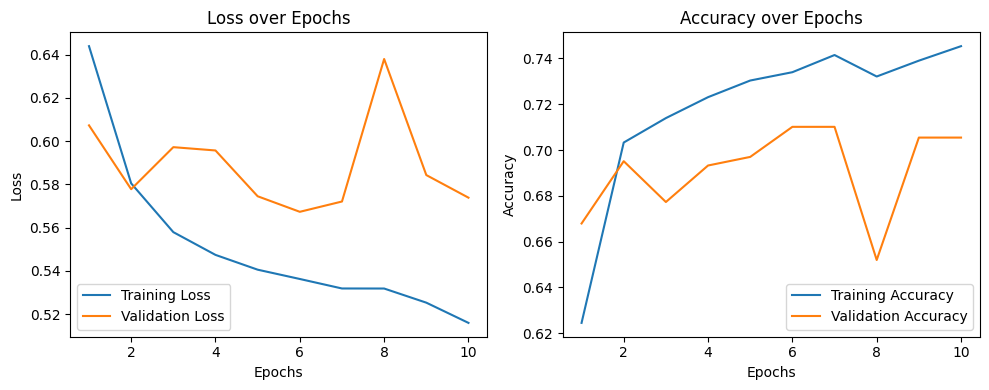

In [48]:
# Define a custom dataset class
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

# Define a collate function for DataLoader
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 32

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
    bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create datasets and dataloaders with the suggested batch size
    train_data = RTDataset(train_dataset, vocab)
    valid_data = RTDataset(validation_dataset, vocab)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model, criterion, and optimizer with the suggested hyperparameters
    output_dim = 2  # Negative or Positive sentiment
    model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
        # Optuna requires a numerical value to minimize (or maximize)
        trial.report(valid_loss, epoch)
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-10-18 22:53:49,995] A new study created in memory with name: no-name-f080ae88-d214-40da-bb23-0cab955b2fe0
C:\Users\Admin\AppData\Local\Temp\ipykernel_33020\3673554983.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-10-18 23:03:52,675] Trial 0 finished with value: 0.6779559205441716 and parameters: {'hidden_dim': 512, 'bidirectional': False, 'lr': 0.0012456052524893997, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6779559205441716.
[I 2024-10-18 23:04:23,181] Trial 1 finished with value: 0.6919086500582955 and parameters: {'hidden_dim': 192, 'bidirectional': True, 'lr': 0.0005943323410566064, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6779559205441716.
[I 2024-10-18 23:04:57,188] Trial 2 finished with value: 0.

Number of finished trials: 20
Best trial:
  Value: 0.5585
  Params:
    hidden_dim: 448
    bidirectional: True
    lr: 0.00026641448147801634
    batch_size: 32
    optimizer: Adam


Epoch 1:
    Train Loss: 0.6849, Train Acc: 0.5454
    Val Loss: 0.6772, Val Acc: 0.5610
Epoch 2:
    Train Loss: 0.6236, Train Acc: 0.6639
    Val Loss: 0.5906, Val Acc: 0.6961
Epoch 3:
    Train Loss: 0.5963, Train Acc: 0.6870
    Val Loss: 0.5981, Val Acc: 0.6914
Epoch 4:
    Train Loss: 0.5816, Train Acc: 0.7013
    Val Loss: 0.5923, Val Acc: 0.6895
Epoch 5:
    Train Loss: 0.5724, Train Acc: 0.7079
    Val Loss: 0.5766, Val Acc: 0.7036
Epoch 6:
    Train Loss: 0.5768, Train Acc: 0.7046
    Val Loss: 0.6351, Val Acc: 0.6398
Epoch 7:
    Train Loss: 0.5737, Train Acc: 0.7054
    Val Loss: 0.5756, Val Acc: 0.7111
Epoch 8:
    Train Loss: 0.5645, Train Acc: 0.7120
    Val Loss: 0.5658, Val Acc: 0.7073
Epoch 9:
    Train Loss: 0.5585, Train Acc: 0.7152
    Val Loss: 0.6001, Val Acc: 0.6857
Epoch 10:
    Train Loss: 0.5648, Train Acc: 0.7163
    Val Loss: 0.5668, Val Acc: 0.7111
Test Loss: 0.5579, Test Acc: 0.7129


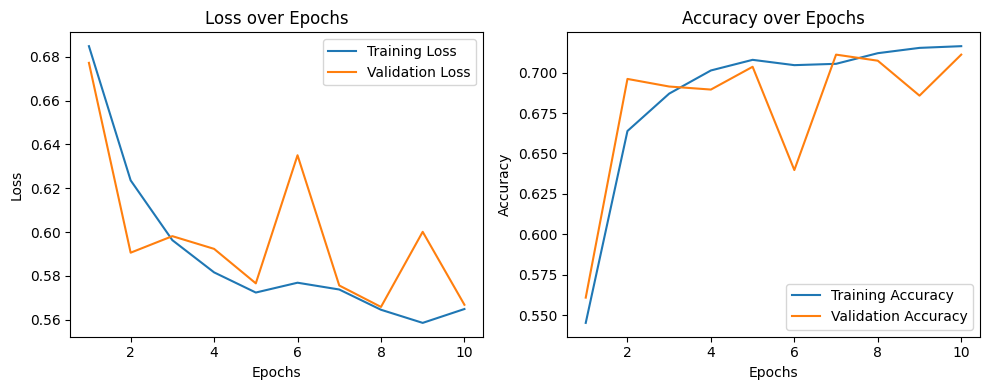

In [45]:
# Define a custom dataset class
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

# Define a collate function for DataLoader
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 64

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        #hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        out = torch.mean(packed_output, dim=1)  # or use torch.max for max-pooling
        output = self.fc(out)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00027498831741916326)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
    bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create datasets and dataloaders with the suggested batch size
    train_data = RTDataset(train_dataset, vocab)
    valid_data = RTDataset(validation_dataset, vocab)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model, criterion, and optimizer with the suggested hyperparameters
    output_dim = 2  # Negative or Positive sentiment
    model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
        # Optuna requires a numerical value to minimize (or maximize)
        trial.report(valid_loss, epoch)
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-10-18 22:41:40,689] A new study created in memory with name: no-name-707cfbf3-60d7-4e6e-bbd3-92e71f3eb136
C:\Users\Admin\AppData\Local\Temp\ipykernel_33020\402606798.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-10-18 22:42:10,440] Trial 0 finished with value: 0.6477346641708718 and parameters: {'hidden_dim': 448, 'bidirectional': False, 'lr': 0.00035544461885855626, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6477346641708718.
[I 2024-10-18 22:42:43,296] Trial 1 finished with value: 0.9491151443789198 and parameters: {'hidden_dim': 320, 'bidirectional': True, 'lr': 0.053161488258758306, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6477346641708718.
[I 2024-10-18 22:43:15,177] Trial 2 finished with value: 0.7

Number of finished trials: 20
Best trial:
  Value: 0.5567
  Params:
    hidden_dim: 128
    bidirectional: True
    lr: 0.00027498831741916326
    batch_size: 64
    optimizer: Adam


# Random embeddings

In [ ]:
# Create word-to-index and index-to-word mappings
vocab = {'<pad>': 0, '<unk>': 1}
index = 2
for word, freq in counter.items():
    vocab[word] = index
    index += 1

idx2word = {idx: word for word, idx in vocab.items()}

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embedding_dim = 100
embeddings_index = load_glove_embeddings('glove_files/glove.6B.100d.txt')

# Create the embedding matrix
count_resolved = 0
count_unresolved = 0
count_lemmatized = 0

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

vocab_size = len(vocab)
# avg = np.mean(list(embeddings_index.values()), axis=0)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
        count_resolved += 1
    else:
        # lemmetize word and use lemmatized embeddings
        lemmatized_word = lemmatizer.lemmatize(word)
        if lemmatized_word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[lemmatized_word]
            count_lemmatized +=1
            count_resolved += 1
        else:

            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
        count_unresolved += 1
print('count resolved:', count_resolved, 'count unresolved:', count_unresolved, 'count lemmatized:', count_lemmatized)

In [ ]:
# Define a custom dataset class
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

# Define a collate function for DataLoader
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 32

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()